# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #4
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, Febrary 23rd, 2018 at 11:00am

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import time
import itertools

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

## Problem 1: Optimization (contd)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A: Further problems with descent algorithms
Using your implementation of gradient descent and stochastic gradient descent, document the behaviour of your two algorithms for the following starting points, and for a number of stepsizes of your choice:
- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$
Based on your analysis of the loss function $L$, explain what is happening to your descent algorithms.

### Answer to Problem 1 Part A

In [2]:
# Load data

data = np.genfromtxt('HW3_data.csv', delimiter=',')
x = data[0, ]
y = data[1, ]
print('Number of data points: {}.'.format(len(x)))

Number of data points: 16000.


In [3]:
# In GD, we use the gradient of total loss at each iteration
# In SGD, we multiply the gradient by total sample size at each iteration

# For the convenience of comparison, we compute the average loss
# when displaying / evaluating results

def L(x, y, lam):
    
    # Average loss   
    
    return np.mean(0.000045 * lam[1]**2 * y - 0.000098 * lam[0]**2 * x \
                 + 0.003926 * lam[0] * x * np.exp((y**2 - x**2) * (lam[0]**2 + lam[1]**2)))

def dL(x, y, lam):
    
    # Gradient of total loss
    
    z = y*y - x*x
    z1 = x*np.exp((lam[0]**2+lam[1]**2)*z)
    a = np.sum(-0.000196*lam[0]*x + (0.003926+0.007852*lam[0]**2*z)*z1)
    b = np.sum(0.00009*lam[1]*y + 0.007852*lam[0]*lam[1]*z*z1)
    return np.array([a, b])

class GD:
    def __init__(self, x, y, lam_init, step=0.001, max_iter=10000, tol=0.001):
        self.name = 'Gradient Descent'
        self.x = deepcopy(x)
        self.y = deepcopy(y)
        self.m = x.size
        self.lam_init = lam_init
        self.step = step
        self.max_iter = max_iter
        self.tol = tol
        self.costs = []
        self.time_ = []
        self.total_time = 0
        self.history = []
        self.iter_ = 0
        
    def run_gd(self):
        
        # Run max_iter iterations
        
        total_start = time.time()
        self.history.append(self.lam_init)
        self.costs.append(L(self.x, self.y, self.lam_init))
        for _ in range(self.max_iter):
            start = time.time()
            self.iter_ += 1
            self.history.append(self.history[-1] - self.step * dL(self.x, self.y, self.history[-1]))
            self.costs.append(L(self.x, self.y, self.history[-1]))
            self.time_.append(time.time() - start)
        self.total_time = time.time() - total_start
        return self
    
    def run_gd_test(self, actual=np.array([2.05384, 0])):
        
        # Run until approaching actual within tol or reaching max_iter
        
        total_start = time.time()
        self.history.append(self.lam_init)
        self.costs.append(L(self.x, self.y, self.lam_init))
        for _ in range(self.max_iter):
            start = time.time()
            self.iter_ += 1
            self.history.append(self.history[-1] - self.step * dL(self.x, self.y, self.history[-1]))
            self.costs.append(L(self.x, self.y, self.history[-1]))
            if np.isnan(self.costs[-1]):
                self.time_.append(time.time() - start)
                break
            if np.linalg.norm(self.history[-1] - actual) <= self.tol:
                self.time_.append(time.time() - start)
                break
            self.time_.append(time.time() - start)
        self.total_time = time.time() - total_start
        return self

class SGD:
    def __init__(self, x, y, lam_init, step=0.001, max_epoch=5, tol=0.001):
        self.name = 'Stochastic Gradient Descent'
        self.x = deepcopy(x)
        self.y = deepcopy(y)
        self.m = x.size
        self.lam_init = lam_init
        self.step = step
        self.max_epoch = max_epoch
        self.tol = tol
        self.costs = []
        self.total_cost = 0
        self.time_ = []
        self.total_time = 0
        self.history = []
        self.iter_ = 0
    
    def run_sgd(self):
        
        # Run until reaching max_epoch
        
        total_start = time.time()
        self.costs.append(L(self.x[0], self.y[0], self.lam_init))
        self.history.append(self.lam_init)
        for _ in range(self.max_epoch):
            for i in range(self.m):
                start = time.time()
                self.iter_ += 1
                self.history.append(self.history[-1]\
                                    - self.step * self.m* dL(self.x[i], self.y[i], self.history[-1]))
                self.total_cost += L(self.x[i], self.y[i], self.history[-1])
                self.costs.append(self.total_cost / self.iter_)
                self.time_.append(time.time() - start)
            neworder = np.random.permutation(self.m)
            self.x = self.x[neworder]
            self.y = self.y[neworder]
        self.total_time = time.time() - total_start
        return self 
    
    def run_sgd_test(self, actual=np.array([2.05384, 0])):
        
        # Run until approaching actual within tol or reaching max_epoch
        
        total_start = time.time()
        self.costs.append(L(self.x[0], self.y[0], self.lam_init))
        self.history.append(self.lam_init)
        done = False
        for _ in range(self.max_epoch):
            for i in range(self.m):
                start = time.time()
                self.iter_ += 1
                self.history.append(self.history[-1]\
                                    - self.step * self.m * dL(self.x[i], self.y[i], self.history[-1]))
                self.total_cost += L(self.x[i], self.y[i], self.history[-1])
                self.costs.append(self.total_cost / self.iter_)
                if np.isnan(self.costs[-1]):
                    done = True
                    self.time_.append(time.time() - start)
                    break
                if np.linalg.norm(self.history[-1] - actual) <= self.tol:
                    done = True
                    self.time_.append(time.time() - start)
                    break
                self.time_.append(time.time() - start)
            if done:
                break
            neworder = np.random.permutation(self.m)
            self.x = self.x[neworder]
            self.y = self.y[neworder]
        self.total_time = time.time() - total_start
        return self

In [4]:
lam_best = np.array([2.05384, 0])
loss_best = L(x, y, lam_best)

In [5]:
# Functions for evaluation / visualization

def print_summary(algo):
    print('----------------')
    print(algo.name)
    print('Starting point: {}.'.format(algo.lam_init))
    print('Number of iterations: {}.'.format(algo.iter_))
    print('Actual optimum: {}.'.format(lam_best))
    print('Final lambda: {}.'.format(algo.history[-1]))
    print('L2 distance to the actual optimum: {}.'.format(np.linalg.norm(algo.history[-1] - lam_best)))
    print('Average loss along the path: {}.'.format(algo.costs[-1]))
    print('Average loss at actual optimum: {}.'.format(loss_best))
    print('Average loss on the dataset: {}.'.format(L(x, y, algo.history[-1])))
    print('Average loss on the dataset - average loss at actual optimum: {}.'\
          .format(L(x, y, algo.history[-1]) - loss_best))
    print('----------------')
        
def plot_3d_hist(gd, \
                 ms=np.linspace(-12, 4, 100), bs = np.linspace(-8, 8, 20), z_offset=-1e-3):
    
    # reference: 
    # https://am207.github.io/2018spring/wiki/gradientdescent.html
    history = gd.history
    costs = gd.costs
    
    M, B = np.meshgrid(ms, bs)
    zs = np.array([L(x, y, l) for l in zip(np.ravel(M), np.ravel(B))])
    Z = zs.reshape(M.shape)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    
    ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    c = ax.contour(M, B, Z, alpha=0.5, offset=z_offset, stride=30)
    
    ax.set_zlim(z_offset, np.max(Z) * 1.1)
    ax.set_xlabel('$\lambda_1$', labelpad=15)
    ax.set_ylabel('$\lambda_2$', labelpad=15)
    ax.set_zlabel('Average $L$', labelpad=15)
    
    fig.colorbar(c, shrink=0.5, aspect=5)
    
    ax.plot([history[-1][0]], [history[-1][1]], [costs[-1]], \
            markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7)
    ax.plot([t[0] for t in history], [t[1] for t in history], costs, alpha=0.5, \
            markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5)
    ax.plot([t[0] for t in history], [t[1] for t in history], z_offset, alpha=0.5, \
            markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    
def plot_all(gds, sgds):
    plt.figure(figsize=(14, 24))
    for i in range(4):
        plt.subplot(4, 2, 2 * i + 1)
        for j in range(3):
            costs = np.array(gds[i][j].costs)
            costs = costs[~np.isnan(costs)]
            l = len(costs)
            plt.plot(np.arange(1, l + 1), costs, alpha=0.6, \
                     label='Learning rate {}\nFinal lambda ({:.4f}, {})'\
                     .format(gds[i][j].step, gds[i][j].history[-1][0], gds[i][j].history[-1][1]))
            plt.title('GD Starting Point ({}, {})'.format(gds[i][j].lam_init[0], gds[i][j].lam_init[1]))
            #plt.xlabel('Iteration No.')
            plt.ylabel('Average loss on the dataset')
            plt.legend()
        
        plt.subplot(4, 2, 2 * i + 2)
        for j in range(3):
            costs = np.array(sgds[i][j].costs)
            #costs = costs[~np.isnan(costs)]
            l = len(costs)
            plt.plot(np.arange(1, l + 1), costs, alpha=0.6, \
                     label='Learning rate {}\nFinal lambda ({:.4f}, {})'\
                     .format(sgds[i][j].step, sgds[i][j].history[-1][0], sgds[i][j].history[-1][1]))
            plt.title('SGD Starting Point ({}, {})'.format(sgds[i][j].lam_init[0], sgds[i][j].lam_init[1]))
            plt.legend()
            #plt.xlabel('Iteration No.')
            plt.ylabel('Average running loss')
            try:
                m = 5e104 if i == 3 else -0.05
                plt.ylim([np.min(costs) * 1.2 , m])
            except:
                pass

In [6]:
lams = [np.array([-2.47865, 0]), \
        np.array([-3, 0]), \
        np.array([-5, 0]), \
        np.array([-10, 0])]

steps = [0.01, 0.001, 0.0001]

gds = [[] for _ in range(4)]
sgds = [[] for _ in range(4)]

In [7]:
%%time

gds = [[GD(x, y, lam, step).run_gd_test() for step in steps] for lam in lams]

Wall time: 1min 22s


In [8]:
%%time

sgds = [[SGD(x, y, lam, step).run_sgd_test() for step in steps] for lam in lams]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Wall time: 6.29 s


In [9]:
for gs in gds:
    for g in gs:
        print_summary(g)
    print()

----------------
Gradient Descent
Starting point: [-2.47865  0.     ].
Number of iterations: 10000.
Actual optimum: [ 2.05384  0.     ].
Final lambda: [-5.36324926  0.        ].
L2 distance to the actual optimum: 7.4170892603377006.
Average loss along the path: 0.0005100955437239633.
Average loss at actual optimum: -0.0006208815015901337.
Average loss on the dataset: 0.0005100955437239633.
Average loss on the dataset - average loss at actual optimum: 0.0011309770453140971.
----------------
----------------
Gradient Descent
Starting point: [-2.47865  0.     ].
Number of iterations: 10000.
Actual optimum: [ 2.05384  0.     ].
Final lambda: [-5.36319794  0.        ].
L2 distance to the actual optimum: 7.4170379444678.
Average loss along the path: 0.0005100955438663277.
Average loss at actual optimum: -0.0006208815015901337.
Average loss on the dataset: 0.0005100955438663277.
Average loss on the dataset - average loss at actual optimum: 0.0011309770454564615.
----------------
-------------

In [10]:
for gs in sgds:
    for g in gs:
        print_summary(g)
    print()

----------------
Stochastic Gradient Descent
Starting point: [-2.47865  0.     ].
Number of iterations: 403.
Actual optimum: [ 2.05384  0.     ].
Final lambda: [ nan   0.].
L2 distance to the actual optimum: nan.
Average loss along the path: nan.
Average loss at actual optimum: -0.0006208815015901337.
Average loss on the dataset: nan.
Average loss on the dataset - average loss at actual optimum: nan.
----------------
----------------
Stochastic Gradient Descent
Starting point: [-2.47865  0.     ].
Number of iterations: 8054.
Actual optimum: [ 2.05384  0.     ].
Final lambda: [ 2.05364425  0.        ].
L2 distance to the actual optimum: 0.0001957475651179763.
Average loss along the path: -0.2919017781109127.
Average loss at actual optimum: -0.0006208815015901337.
Average loss on the dataset: -0.0006208814949922327.
Average loss on the dataset - average loss at actual optimum: 6.597900936537726e-12.
----------------
----------------
Stochastic Gradient Descent
Starting point: [-2.47865  

In GD, it converges to another local optimum for all the starting points we tested here when the learning rate is not too low or there are enough iterations.

We can visualize GD result for the first $\lambda$ and learning rate we tested in 3D and contour plots of average loss on the entire dataset as follows.

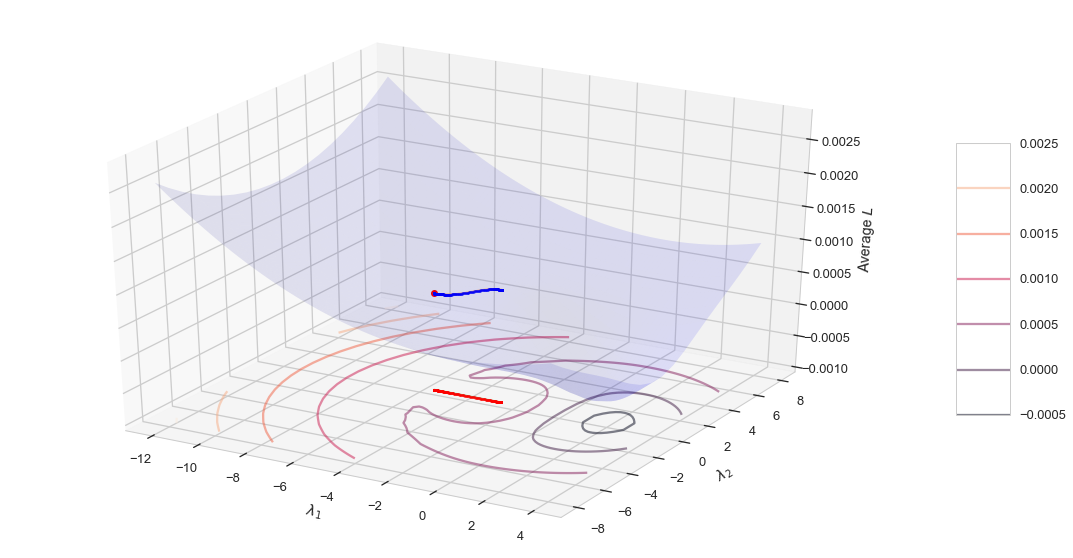

In [11]:
plot_3d_hist(gds[0][0])

As we can see, the initial gradient guides it to another local optimum, and as a result it converges to the other one. The situations are similar for other 3 starting points we choose here.

To better understand the behaviour of 2 algorithms in these cases, we can plot the loss function at each iteration. Sepecifically,
1. For GD, we plot the average loss on the entire dataset at each iteration.
2. For SGD, we plot the average running loss at each iteration.

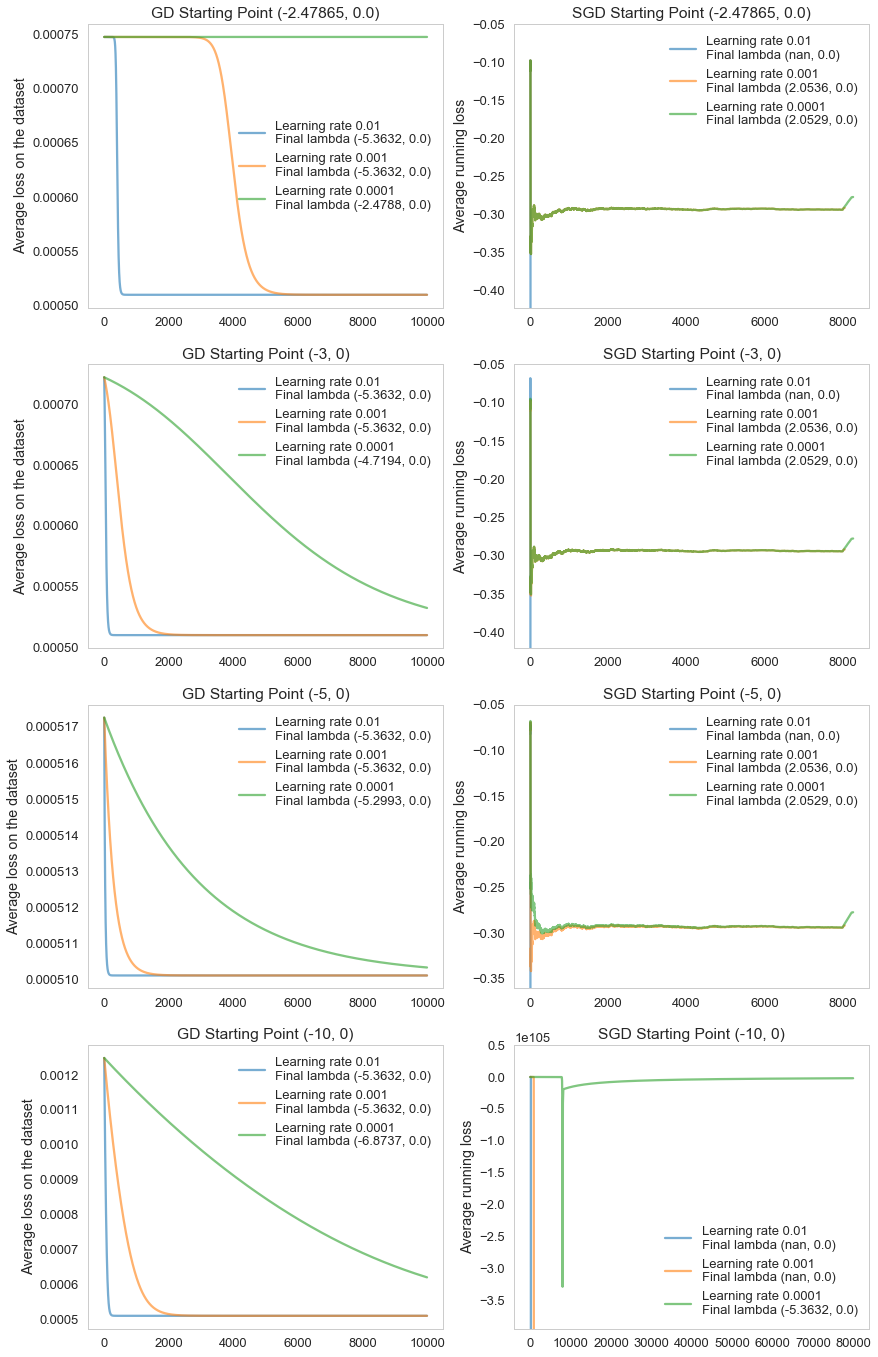

In [12]:
plot_all(gds, sgds)

In GD case, we observe the algorithm converges to another local optimum when the learning rate is large enough for all starting points we tested here. The reason is that the gradient at the starting point points to this local optimum, and eventually it converges to the point. For those small learning rates, we would also see GD converges at the same point if we run for enough iterations.

In SGD case, we observe the algorithm "reaches" the actual optimum for the first 3 starting points when the learning rate is not too high. SGD seems to converge to another point for the 4th starting point when the learning rate is not too high. Overflow error occurs for high learning rates.

For the first 3 starting points, it seems SGD "bumped into" the optimum we were waiting for rather than finding the optimum. If we don't know the optimum beforehand, SGD might not converge there since it hasn't even iterated through all data points. It doesn't happend for the 4th starting point, presumably because the starting point is too far away from the optimum.

## Problem 2: Logistic Regression and MNIST (contd)




The MNIST dataset is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves. It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. 

Last time you used PyTorch to build a handwritten digit multi-class logistic regression classifier that you trained and tested with MNIST dataset.

We'll introduce validation sets and regularization in this problem.

Using the softmax formulation, write a PyTorch model that computes the cost function using an L2 regularization approach (see `optim.SGD` in PyTorch or write your own cost function) and minimizes the resulting cost function using mini-batch stochastic gradient descent.

Construct and train your classifier using a batch size of 256 examples, a learning rate η=0.1, and a regularization factor λ=0.01.

1. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains. 
2. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for different values of λ? Give an approximate answer supported by using the plots.
3. Select what you consider the best regularization parameter and predict the labels of the test set. Compare with the given labels. What classification accuracy do you obtain on the test set?

### Answer to Problem 2

In [2]:
def train_cv_split(dataset, batch_size=256, cv_size=0.1, shuffle=False):
    trainset = deepcopy(dataset)
    cvset = deepcopy(dataset)
    n = len(trainset)
    inds = list(range(n))
    split = int(np.floor(cv_size * n))
    if shuffle:
        np.random.shuffle(inds)
    train_sampler = SubsetRandomSampler(inds[split:])
    cv_sampler = SubsetRandomSampler(inds[:split])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, \
                                              sampler=train_sampler)
    cvloader = torch.utils.data.DataLoader(cvset, batch_size=split, sampler=cv_sampler)
    return trainloader, cvloader

In [3]:
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.MNIST(root='', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='', train=False, transform=transform)

trainloader, cvloader = train_cv_split(trainset)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)

In [4]:
def getData(testloader):
    return iter(testloader).next()

def accuracy_score(y_true, y_pred, verbose=False):
    if not verbose:
        return np.mean(y_true == y_pred)
    else:
        return np.array([np.mean(y_pred_test[y_test == i] == i) for i in range(10)])

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = nn.Linear(28 * 28, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.view(x.shape[0], 28*28)
        return self.logsoftmax(self.linear(x))

    
class MLR:
    def __init__(self, lr=0.1, weight_decay=0, max_epoch=10):
        self.max_epoch = max_epoch
        self.weight_decay = weight_decay
        self.lr = lr
        self.model = Model()
        self.criterion = nn.NLLLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.loss_ = []
        self.cv_accuracy = []
        
    def fit(self, trainloader, cvloader=None, verbose=True):
        print('Learning rate: {}; regularization factor: {}'.format(self.lr, self.weight_decay))
        if cvloader is not None:
            x, y = getData(cvloader)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
                self.loss_.append(loss.data[0])
            if verbose:
                print('Epoch {} loss: {}'.format(epoch + 1, running_loss / len(trainloader)))
            if cvloader is not None:
                self.cv_accuracy.append(self.score(x, y))
                if verbose:
                    print('Accuracy on the validation set: {}'.format(self.cv_accuracy[-1]))
        print('Finished Training.')
        return self

    def predict(self, x):
        outputs = self.model(Variable(deepcopy(x)))
        _, pred = torch.max(outputs.data, 1)
        return pred
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    


#### 1. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

We construct a validation set by spliting 10% of data from training set.

In [5]:
%%time

mlrs = [MLR(lr=0.1, weight_decay=0.01, max_epoch=15).fit(trainloader, cvloader)]

Learning rate: 0.1; regularization factor: 0.01
Epoch 1 loss: 1.0972336909217293
Accuracy on the validation set: 0.8861666666666667
Epoch 2 loss: 0.42335773898526957
Accuracy on the validation set: 0.8825
Epoch 3 loss: 0.4029752054203178
Accuracy on the validation set: 0.8665
Epoch 4 loss: 0.3935509550062966
Accuracy on the validation set: 0.829
Epoch 5 loss: 0.3818935739909303
Accuracy on the validation set: 0.9086666666666666
Epoch 6 loss: 0.38887654033034896
Accuracy on the validation set: 0.9091666666666667
Epoch 7 loss: 0.3766428678521613
Accuracy on the validation set: 0.8935
Epoch 8 loss: 0.39371723374484274
Accuracy on the validation set: 0.9015
Epoch 9 loss: 0.37756998618067156
Accuracy on the validation set: 0.8888333333333334
Epoch 10 loss: 0.382991455036317
Accuracy on the validation set: 0.8963333333333333
Epoch 11 loss: 0.361583786411873
Accuracy on the validation set: 0.9108333333333334
Epoch 12 loss: 0.38425463176734076
Accuracy on the validation set: 0.884
Epoch 13 los

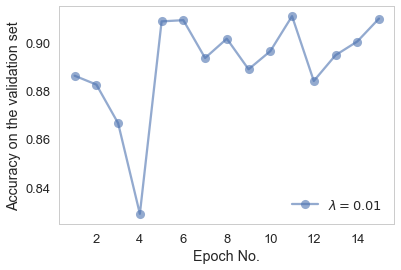

In [6]:
plt.plot(np.arange(1, len(mlrs[0].cv_accuracy)+1), mlrs[0].cv_accuracy, 'o-', \
        alpha=0.6, label='$\lambda={}$'.format(mlrs[0].weight_decay));
plt.xlabel('Epoch No.');
plt.ylabel('Accuracy on the validation set');
plt.legend();

#### 2. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for different values of λ? Give an approximate answer supported by using the plots.

In [7]:
%%time

lams = [1, 0.1, 0.01, 0.001, 0.0001, 0]
mlrs = [MLR(lr=0.1, weight_decay=w).fit(trainloader, cvloader, verbose=False) for w in lams]

Learning rate: 0.1; regularization factor: 1
Finished Training.
Learning rate: 0.1; regularization factor: 0.1
Finished Training.
Learning rate: 0.1; regularization factor: 0.01
Finished Training.
Learning rate: 0.1; regularization factor: 0.001
Finished Training.
Learning rate: 0.1; regularization factor: 0.0001
Finished Training.
Learning rate: 0.1; regularization factor: 0
Finished Training.
CPU times: user 20min 21s, sys: 1min 34s, total: 21min 56s
Wall time: 8min 17s


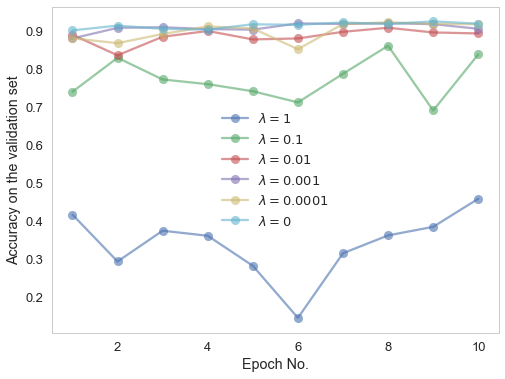

In [8]:
plt.figure(figsize=(8, 6))
for i in range(len(mlrs)):
    plt.plot(np.arange(1, len(mlrs[i].cv_accuracy)+1), mlrs[i].cv_accuracy, 'o-', \
             alpha=0.6, label='$\lambda={}$'.format(mlrs[i].weight_decay));
plt.xlabel('Epoch No.');
plt.ylabel('Accuracy on the validation set');
plt.legend();

As we can see, 
1. The accuracy on the validation set wouldn't be significantly higher than the first point where the accuracy on the validation set starts decreasing compared to the previous epoch.
2. The accuracy on the validation set would increase at some point after the first time it decreases from the previous epoch.

Ideally, we should stop training when the algorithm converges. In this case, we can stop training at the point where the validation accuracy starts increasing after the first time we see it decreasing from the previous epoch.

#### 3. Select what you consider the best regularization parameter and predict the labels of the test set. Compare with the given labels. What classification accuracy do you obtain on the test set?

As we can see, the accuracy on the validation set barely changes when the regularization parameter is equal to or lower than 0.001, and is lower for higher regularization parameters, indicating regularization might not be necessary in this case.

We choose the regularization parameter which ends up in highest accuracy on the validation set.

In [9]:
i_best = np.argmax([mlr.cv_accuracy[-1] for mlr in mlrs])
mlr = mlrs[i_best]

print('The best regularization parameter determined by validation accuracy is {}.'.format(mlr.weight_decay))
print()
x_test, y_test = getData(testloader)
y_pred_test = mlr.predict(x_test)

accu_test = accuracy_score(y_test, y_pred_test, verbose=True)

print('Accuracy on the test set:')
print('Overall accuracy : {:.4f}'.format(accuracy_score(y_test, y_pred_test)))
for i in range(10):
    print('Accuracy of {} : {:.4f}'.format(i, accu_test[i]))

The best regularization parameter determined by validation accuracy is 0.

Accuracy on the test set:
Overall accuracy : 0.9173
Accuracy of 0 : 0.9663
Accuracy of 1 : 0.9824
Accuracy of 2 : 0.9244
Accuracy of 3 : 0.9109
Accuracy of 4 : 0.8859
Accuracy of 5 : 0.8868
Accuracy of 6 : 0.9457
Accuracy of 7 : 0.9115
Accuracy of 8 : 0.8111
Accuracy of 9 : 0.9346


## Problem 3: Multi-Layer Perceptron

The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is usually chosen to be either the logistic function or the $\tanh$ function or the RELU function, and its purpose is to project the data into a space where it becomes linearly separable The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. 

![](http://deeplearning.net/tutorial/_images/mlp.png)

We'll construct a model with **1 hidden layer**. That is, you will have an input layer with a nonlinearity, then a hidden layer with the nonlinearity, and finally a cross-entropy (or equivalently log-softmax with a log-loss)


Using a similar architecture as in the first part and the same training, validation, and test sets, build a PyTorch model for the multilayer perceptron. Use the $\tanh$ function as the non-linear activation function. 

1. Use $\lambda = 0.001$ to compare with Problem 2. Experiment with the learning rate (try 0.1 and 0.01 for example), batch size (use 20, 50, 100 and 200) and the number of units in your hidden layer (use between 25 and 100 units). For what combination of these parameters do you obtain the highest validation accuracy after a resonable number of epochs that lead to convergence ( start at 10 epochs and play around a bit for convergence)? How does your test accuracy compare to the logistic regression classifier?
2. Try the same values of $\lambda$ you used in Question 2. Does the test set accuracy improve?


*Hint #1:* The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, you may find it advisable to initialize with the interval $[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.

*Hint #2*
Train/Validate/Test split can be done in numpy or in PyTorch. Lab will describe a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`: see the docs.

### Answer to Problem 3

In [10]:
def train_cv_split(dataset, batch_size=256, cv_size=0.1, shuffle=False):
    
    # It ensures same validation set when same dataset is passed in, and shuffle is False
    
    trainset = deepcopy(dataset)
    cvset = deepcopy(dataset)
    n = len(trainset)
    inds = list(range(n))
    split = int(np.floor(cv_size * n))
    if shuffle:
        np.random.shuffle(inds)
    train_sampler = SubsetRandomSampler(inds[split:])
    cv_sampler = SubsetRandomSampler(inds[:split])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, \
                                              sampler=train_sampler)
    cvloader = torch.utils.data.DataLoader(cvset, batch_size=split, sampler=cv_sampler)
    return trainloader, cvloader

class MLP(nn.Module):
    def __init__(self, hidden_dim):
        super(MLP, self).__init__()
        self.input = nn.Linear(28*28, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.final = nn.Linear(hidden_dim, 10)
        self.logsoftmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.view(x.shape[0], 28*28)
        x = F.tanh(self.input(x))
        x = F.tanh(self.hidden(x))
        x = self.logsoftmax(self.final(x))
        return x
    
class MLPClassifier:
    def __init__(self, lr=0.1, batch_size=50, hidden_dim=50, weight_decay=0.001, max_epoch=12):
        self.lr = lr
        self.batch_size=batch_size
        self.hidden_dim = hidden_dim
        self.weight_decay = weight_decay
        self.max_epoch = max_epoch
        self.model = MLP(hidden_dim=hidden_dim)
        self.criterion = nn.NLLLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.loss_ = []
        self.cv_accuracy = []
        self.loss_epoch = []
    
    def fit(self, trainset, verbose=True):
        # Same validation set is ensured for same trainset
        trainloader, cvloader = train_cv_split(trainset, self.batch_size)
        x, y = getData(cvloader)
        print(self)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
                self.loss_.append(loss.data[0])
            self.loss_epoch.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch + 1, self.loss_epoch[-1]))               
            self.cv_accuracy.append(self.score(x, y))
            if verbose or epoch + 1 == self.max_epoch:
                print('Accuracy on the validation set: {}'.format(self.cv_accuracy[-1]))
        print('Finished Training.')
        return self
    
    def __str__(self):
        return 'lr {}; batch_size {}; hidden_dim {}; lambda {}; max_epoch {}'\
    .format(self.lr, self.batch_size, self.hidden_dim, self.weight_decay, self.max_epoch)
    
    def predict(self, x):
        outputs = self.model(Variable(deepcopy(x)))
        _, pred = torch.max(outputs.data, 1)
        return pred
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

#### Question 3.1

After a few trials, we decide to set `max_epoch` to 12.

In [11]:
%%time
lrs = [0.1, 0.01]
batch_sizes = [20, 50, 100, 200]
hidden_dims = [25, 50, 100]

mlps = [[[MLPClassifier(lr=lr, batch_size=b, hidden_dim=h).fit(trainset, verbose=False) \
         for h in hidden_dims] for b in batch_sizes] for lr in lrs]

lr 0.1; batch_size 20; hidden_dim 25; lambda 0.001; max_epoch 12
Accuracy on the validation set: 0.9425
Finished Training.
lr 0.1; batch_size 20; hidden_dim 50; lambda 0.001; max_epoch 12
Accuracy on the validation set: 0.9628333333333333
Finished Training.
lr 0.1; batch_size 20; hidden_dim 100; lambda 0.001; max_epoch 12
Accuracy on the validation set: 0.967
Finished Training.
lr 0.1; batch_size 50; hidden_dim 25; lambda 0.001; max_epoch 12
Accuracy on the validation set: 0.9471666666666667
Finished Training.
lr 0.1; batch_size 50; hidden_dim 50; lambda 0.001; max_epoch 12
Accuracy on the validation set: 0.9566666666666667
Finished Training.
lr 0.1; batch_size 50; hidden_dim 100; lambda 0.001; max_epoch 12
Accuracy on the validation set: 0.9663333333333334
Finished Training.
lr 0.1; batch_size 100; hidden_dim 25; lambda 0.001; max_epoch 12
Accuracy on the validation set: 0.869
Finished Training.
lr 0.1; batch_size 100; hidden_dim 50; lambda 0.001; max_epoch 12
Accuracy on the validati

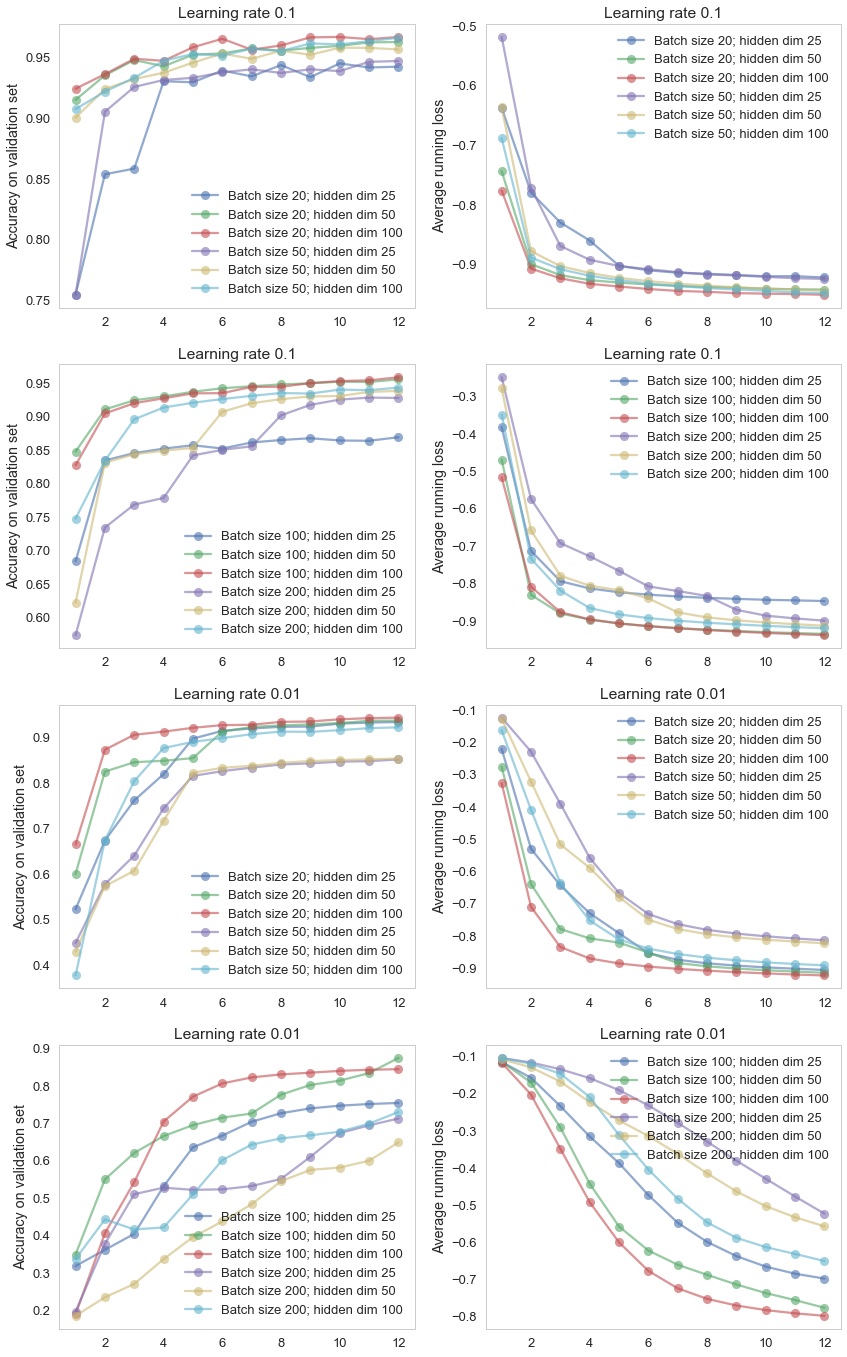

In [12]:
inds = list(itertools.product((0, 1), (0, 1, 2, 3), (0, 1, 2)))

plt.figure(figsize=(14, 24))

for _i, ind in enumerate(np.array_split(inds, 4)):
    plt.subplot(4, 2, _i * 2 + 1)
    for i in ind:
        mlp = mlps[i[0]][i[1]][i[2]]
        plt.plot(np.arange(1, mlp.max_epoch + 1), mlp.cv_accuracy, 'o-', alpha=0.6, \
                 label='Batch size {}; hidden dim {}'.format(mlp.batch_size, mlp.hidden_dim));
    plt.legend()
    plt.ylabel('Accuracy on validation set')
    plt.title('Learning rate {}'.format(mlp.lr))
    
    plt.subplot(4, 2, _i * 2 + 2)
    for i in ind:
        mlp = mlps[i[0]][i[1]][i[2]]
        plt.plot(np.arange(1, mlp.max_epoch + 1), mlp.loss_epoch, 'o-', alpha=0.6, \
                 label='Batch size {}; hidden dim {}'.format(mlp.batch_size, mlp.hidden_dim));
    plt.legend()
    plt.ylabel('Average running loss')
    plt.title('Learning rate {}'.format(mlp.lr))

It takes longer to converge for smaller learning rate. It doesn't converge for some parameters (with smaller learning rate) within 12 epoches, but we don't go further for these groups since corresponding groups with larger learning rate behave very well. 

In [13]:
mlps_ = [mlps[i[0]][i[1]][i[2]] for i in inds]
i_best = np.argmax([mlp.cv_accuracy[-1] for mlp in mlps_])
mlp_best = mlps_[i_best]
print('Parameters with highest accuracy on the validation set:')
print(mlp_best)
print()

x_test, y_test = getData(testloader)
y_pred_test = mlp_best.predict(x_test)

accu_test = accuracy_score(y_test, y_pred_test, verbose=True)

print('Accuracy on the test set:')
print('Overall accuracy : {:.4f}'.format(accuracy_score(y_test, y_pred_test)))
for i in range(10):
    print('Accuracy of {} : {:.4f}'.format(i, accu_test[i]))

Parameters with highest accuracy on the validation set:
lr 0.1; batch_size 20; hidden_dim 100; lambda 0.001; max_epoch 12

Accuracy on the test set:
Overall accuracy : 0.9644
Accuracy of 0 : 0.9755
Accuracy of 1 : 0.9877
Accuracy of 2 : 0.9671
Accuracy of 3 : 0.9752
Accuracy of 4 : 0.9593
Accuracy of 5 : 0.9563
Accuracy of 6 : 0.9781
Accuracy of 7 : 0.9212
Accuracy of 8 : 0.9569
Accuracy of 9 : 0.9643


Test accuracy is higher than that of logistic regression classifier.

#### Question 3.2

We use the best parameters chosen from the previous part and tune $\lambda$ only.

In [17]:
%%time

lams = [0.01, 0.001, 0.0001, 0]

mlps2 = [MLPClassifier(lr=mlp_best.lr, batch_size=mlp_best.batch_size, \
                       hidden_dim=mlp_best.hidden_dim, weight_decay=l)\
         .fit(trainset, verbose=False) for l in lams]

lr 0.1; batch_size 20; hidden_dim 100; lambda 0.01; max_epoch 12
Accuracy on the validation set: 0.8868333333333334
Finished Training.
lr 0.1; batch_size 20; hidden_dim 100; lambda 0.001; max_epoch 12
Accuracy on the validation set: 0.9595
Finished Training.
lr 0.1; batch_size 20; hidden_dim 100; lambda 0.0001; max_epoch 12
Accuracy on the validation set: 0.971
Finished Training.
lr 0.1; batch_size 20; hidden_dim 100; lambda 0; max_epoch 12
Accuracy on the validation set: 0.9653333333333334
Finished Training.
CPU times: user 23min 54s, sys: 1min 37s, total: 25min 31s
Wall time: 9min 16s


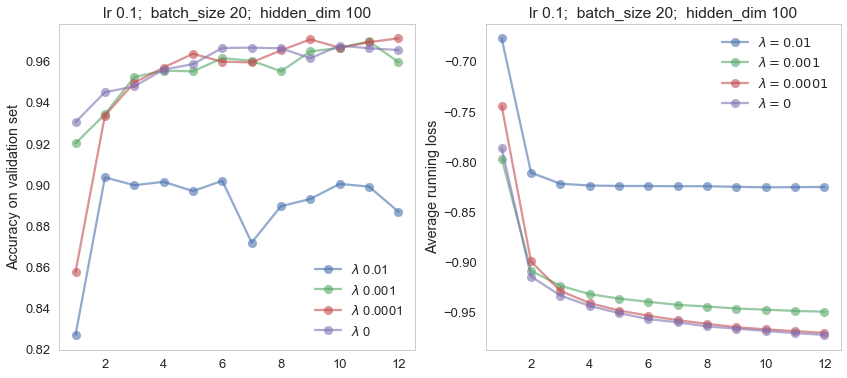

In [18]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for mlp in mlps2:
    plt.plot(np.arange(1, mlp.max_epoch + 1), mlp.cv_accuracy, 'o-', alpha=0.6, \
             label='$\lambda$ {}'.format(mlp.weight_decay));
plt.legend()
plt.ylabel('Accuracy on validation set')
plt.title('; '.join(str(mlp).split(';')[:3]))

plt.subplot(1, 2, 2)
for mlp in mlps2:
    plt.plot(np.arange(1, mlp.max_epoch + 1), mlp.loss_epoch, 'o-', alpha=0.6, \
             label='$\lambda = {}$'.format(mlp.weight_decay));
plt.legend()
plt.ylabel('Average running loss')
plt.title('; '.join(str(mlp).split(';')[:3]));

The validation accuracy is lower for high regularization parameter, presumably due to the high consistency of the training and validation data.

In [19]:
i_best = np.argmax([mlp.cv_accuracy[-1] for mlp in mlps2])
mlp_best2 = mlps2[i_best]
print('Parameters with highest accuracy on the validation set:')
print(mlp_best2)
print('Best lambda: {}'.format(mlp_best2.weight_decay))
print()

x_test, y_test = getData(testloader)
y_pred_test = mlp_best2.predict(x_test)

accu_test = accuracy_score(y_test, y_pred_test, verbose=True)

print('Accuracy on the test set:')
print('Overall accuracy : {:.4f}'.format(accuracy_score(y_test, y_pred_test)))
for i in range(10):
    print('Accuracy of {} : {:.4f}'.format(i, accu_test[i]))

Parameters with highest accuracy on the validation set:
lr 0.1; batch_size 20; hidden_dim 100; lambda 0.0001; max_epoch 12
Best lambda: 0.0001

Accuracy on the test set:
Overall accuracy : 0.9681
Accuracy of 0 : 0.9847
Accuracy of 1 : 0.9947
Accuracy of 2 : 0.9700
Accuracy of 3 : 0.9743
Accuracy of 4 : 0.9511
Accuracy of 5 : 0.9496
Accuracy of 6 : 0.9791
Accuracy of 7 : 0.9679
Accuracy of 8 : 0.9466
Accuracy of 9 : 0.9574


Test accuracy improves slightly compared to the previous part.